# Heart Disease Prediction with Logistic Regression

In [1]:
# Load Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from matplotlib.cm import rainbow
import sklearn
import seaborn as sns
import warnings

import pandas_profiling as pp

import statsmodels.api as sm
import statsmodels.tsa.api as smt
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

from IPython.display import display
warnings.filterwarnings('ignore')

from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 16, 10
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

np.random.seed(123)

### Initial Data Exploration

In [2]:
#Read the dataset and view features
data = pd.read_csv("data3.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    object 
 12  thal      303 non-null    object 
 13  num       303 non-null    int64  
dtypes: float64(1), int64(11), object(2)
memory usage: 33.3+ KB


In [3]:
# Data Profiling
pp.ProfileReport(data)

<b>Elaborating the Levels in "thal" and "cal" features</b>
+ The "thal" and "cal" features have "?" as a category. Mode imputation can be done but not required as they are only a few of these dirty instances. 

In [4]:
#Removing all instances with "?"

levels_in_ca =list(data['ca'].value_counts().index)
levels_in_thal =list(data['thal'].value_counts().index)

In [5]:
levels_in_ca

['0', '1', '2', '3', '?']

In [6]:
levels_in_thal

['3', '7', '6', '?']

<AxesSubplot:>

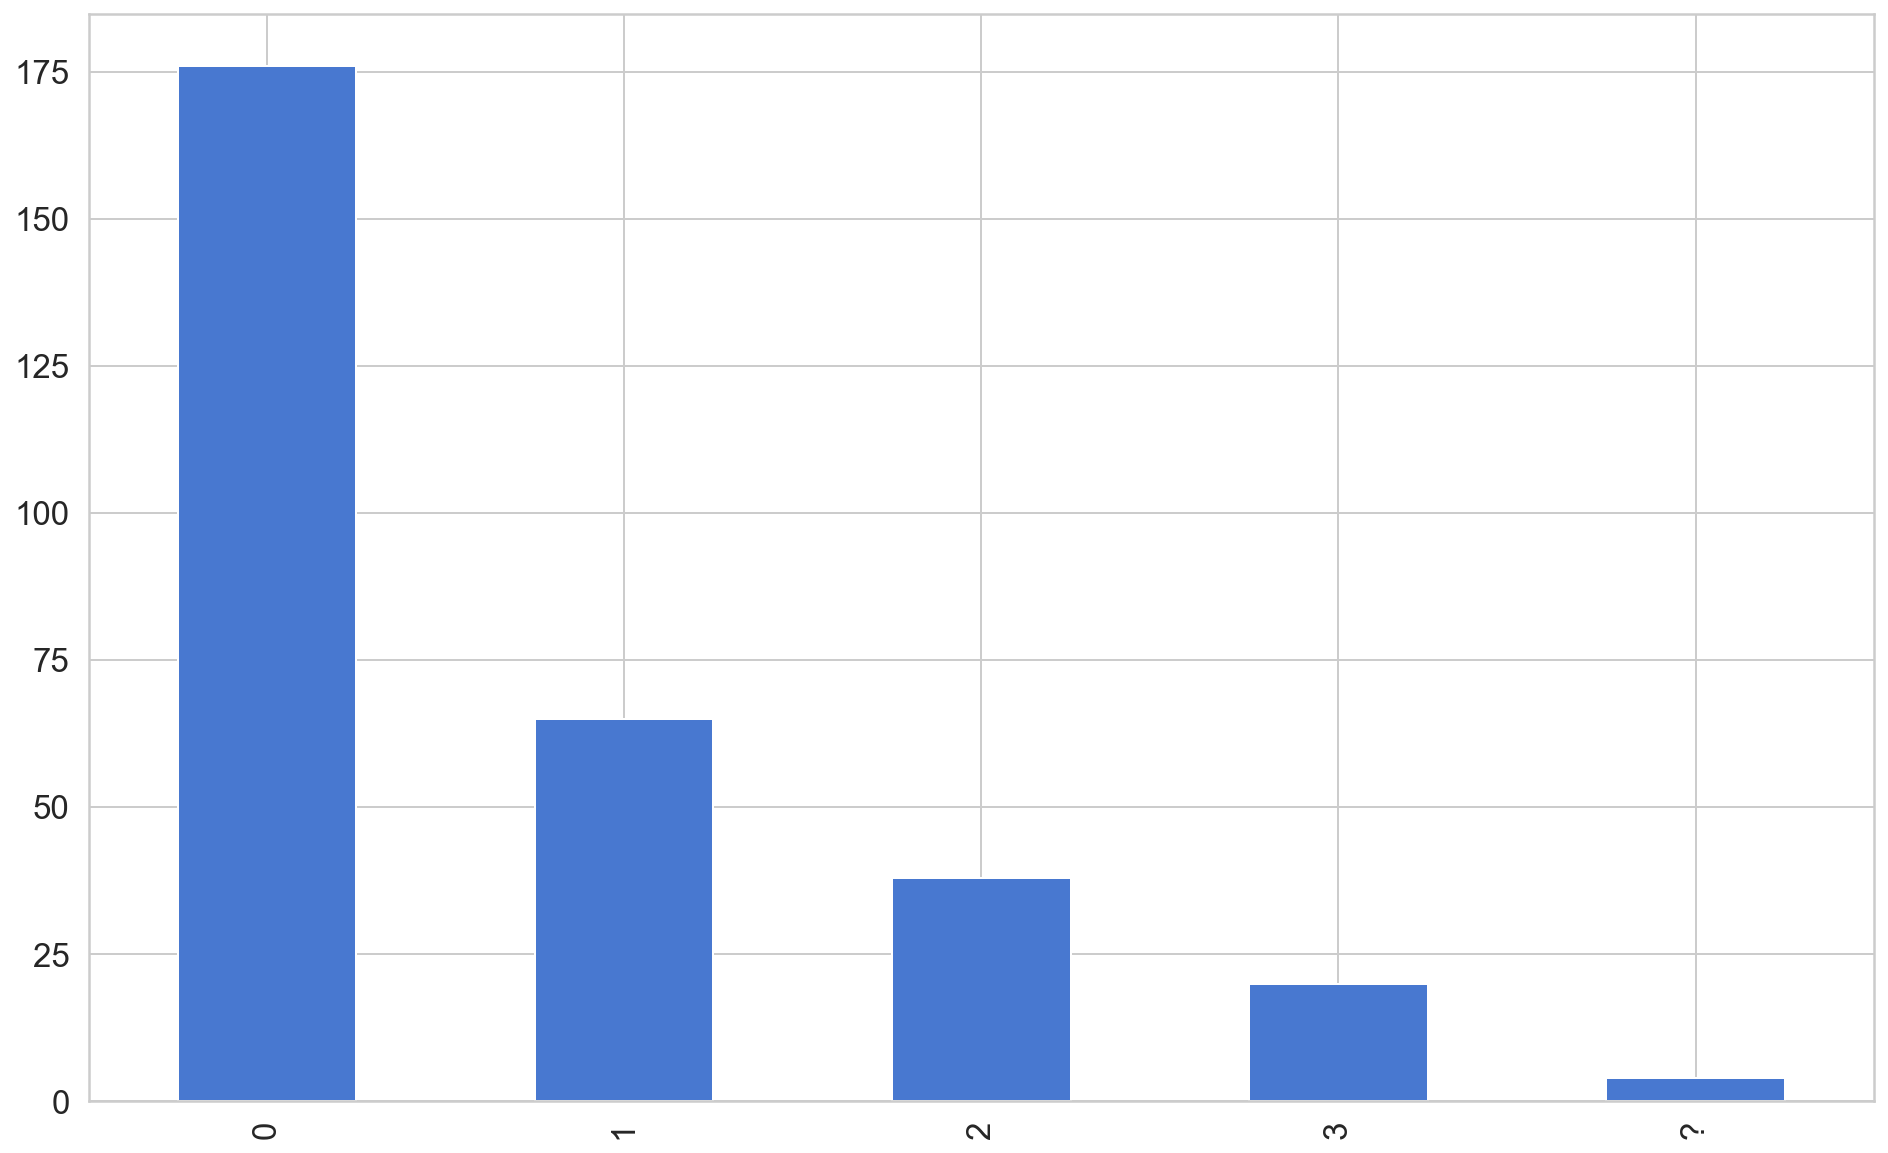

In [7]:
# Plotting these levels
data['ca'].value_counts().head(10).plot.bar()

<AxesSubplot:>

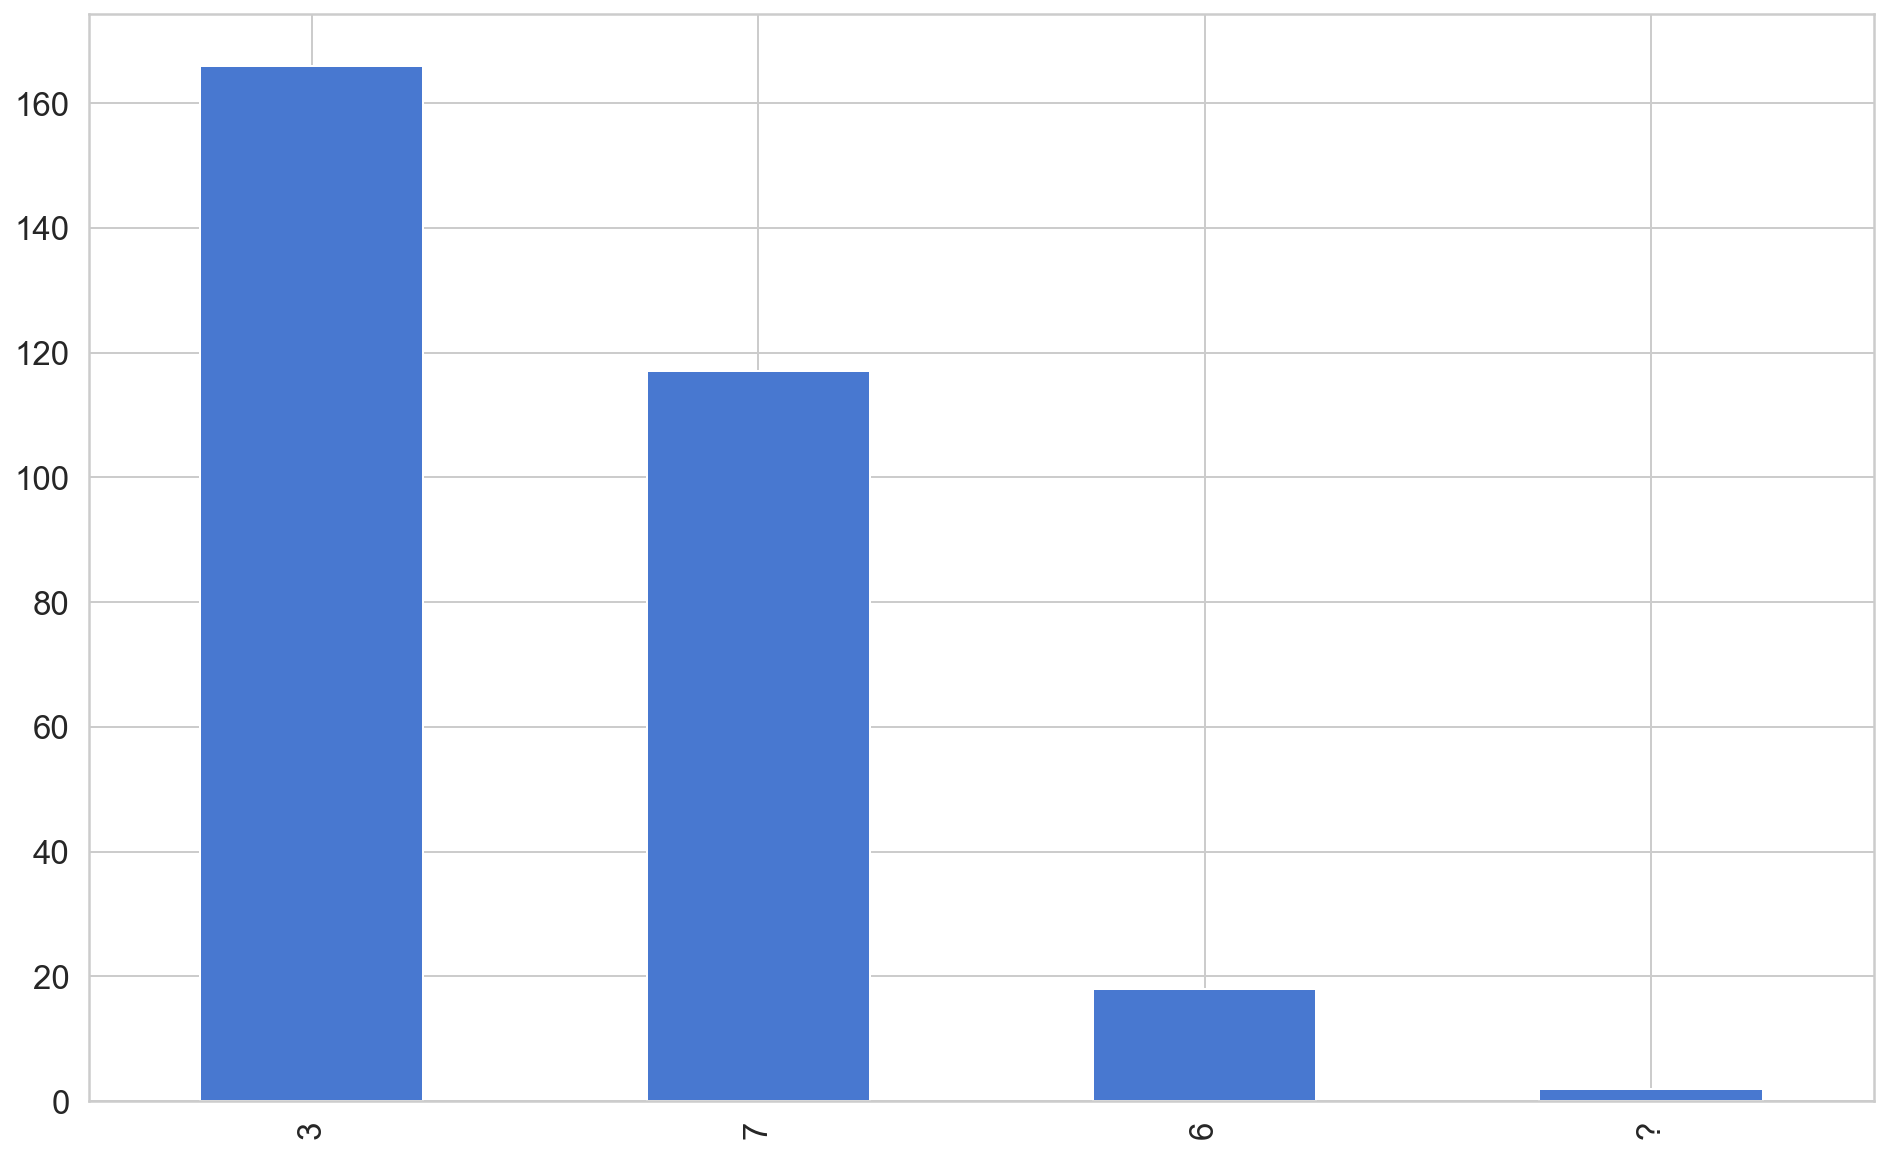

In [8]:
data['thal'].value_counts().head(10).plot.bar()

In [9]:
# Dropping rows with "?" values AND creating new copy of dataset

data = data[~(data.values == '?').any(1)]

In [10]:
data

age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
0     63    1   1       145   233    1        2      150      0      2.3   
1     67    1   4       160   286    0        2      108      1      1.5   
2     67    1   4       120   229    0        2      129      1      2.6   
3     37    1   3       130   250    0        0      187      0      3.5   
4     41    0   2       130   204    0        2      172      0      1.4   
..   ...  ...  ..       ...   ...  ...      ...      ...    ...      ...   
297   57    0   4       140   241    0        0      123      1      0.2   
298   45    1   1       110   264    0        0      132      0      1.2   
299   68    1   4       144   193    1        0      141      0      3.4   
300   57    1   4       130   131    0        0      115      1      1.2   
301   57    0   2       130   236    0        2      174      0      0.0   

     slope ca thal  num  
0        3  0    6    0  
1        2  3    3    2  
2        2  2    7    1  
3        3  0    3    0  
4        1  0    3    0  
..     ... ..  ...  ...  
297      2  0    7    1  
298      2  0    7    1  
299      2  2    7    2  
300      2  1    7    3  
301      2  1    3    1  

[297 rows x 14 columns]

In [11]:
data.dtypes

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca           object
thal         object
num           int64
dtype: object

In [12]:
# Only consider these three variables for the conversion

data["ca"] = data["ca"].astype(str).astype(int)
data["thal"] = data["thal"].astype(str).astype(int)
data['oldpeak'] = data['oldpeak'].astype(np.int64)

# Confirm datatype conversion

print (data.dtypes)

age         int64
sex         int64
cp          int64
trestbps    int64
chol        int64
fbs         int64
restecg     int64
thalach     int64
exang       int64
oldpeak     int64
slope       int64
ca          int64
thal        int64
num         int64
dtype: object


### Target Variable Inspection and Feature Engineering

(a) View Target Variable and Document.

(b) Feature Engineering: The goal is to simply attempting to distinguish presence of CHD (num values 1,2,3,4) from absence (num value 0).

(c) Final Class Balancing Report.

0   53.9
1   18.2
3   11.8
2   11.8
4    4.4
Name: num, dtype: float64


<AxesSubplot:xlabel='num', ylabel='count'>

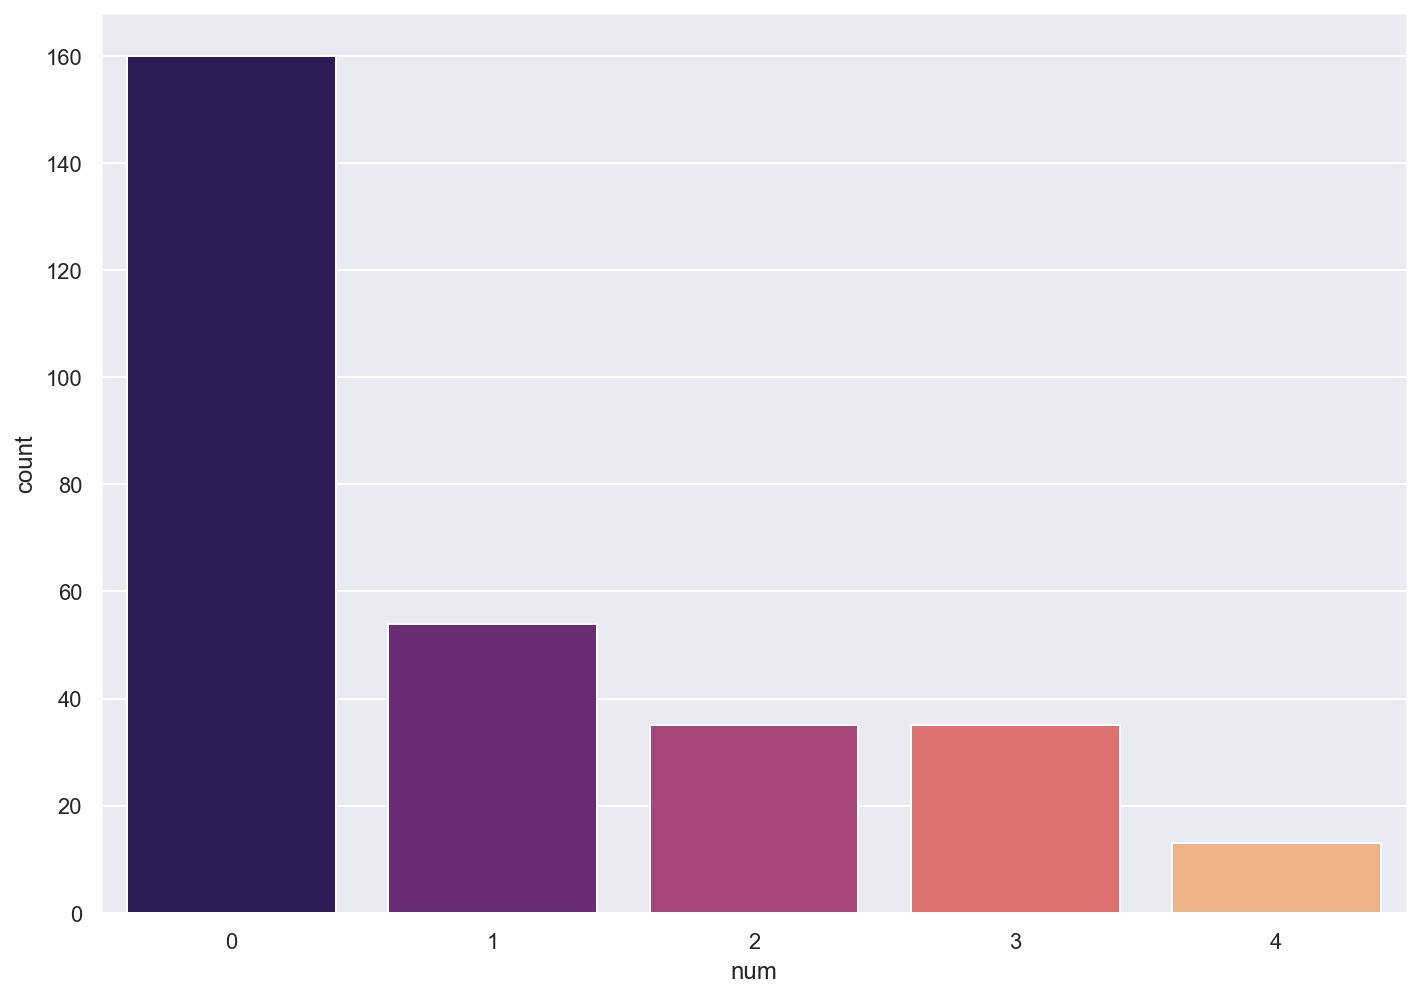

In [13]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

# Get a count of the number of num'0','1','2','3' and '4' records, num is the target variable to detect presence of CHD
pd.options.display.float_format = "{:,.1f}".format # display float values to one decimal places.

print(data['num'].value_counts(0)/data.shape[0]*100)

#Visualize this count 
sns.countplot(x='num', data=data, palette='magma')


### Feature Engineering: Generating a Binary Target Feature

In [14]:
# Updating the Target Variable's Value according to the given rule below;
# The goal is to simply attempting to distinguish presence of CHD (num values 1,2,3,4) from absence (num value 0).

data['num'] = data['num'].replace({2: 1,3: 1,4: 1 })

### Final Class Balancing Report

In [15]:
#Visualize this count 
rcParams['figure.figsize'] = 8,6
plt.bar(data['num'].unique(), data['num'].value_counts(), color = ['orange', 'indigo'])
plt.xticks([0, 1])
plt.xlabel('Target Classes')
plt.ylabel('Count')
plt.title(' TARGET CLASSES REPRESENTATION')

print(data['num'].value_counts(0)/data.shape[0]*100)

0   53.9
1   46.1
Name: num, dtype: float64


### Exploratory Data Analysis

<AxesSubplot:xlabel='thalach', ylabel='Density'>

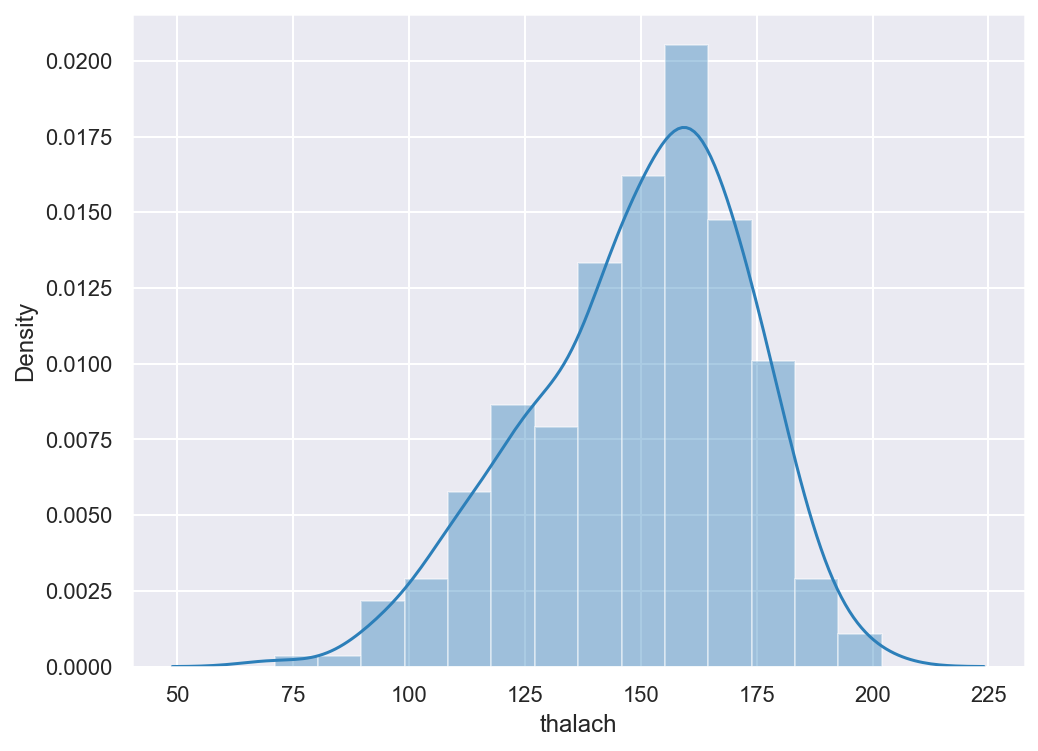

In [16]:
sns.distplot(data.thalach, color="#2c7fb9")

<AxesSubplot:xlabel='chol', ylabel='Density'>

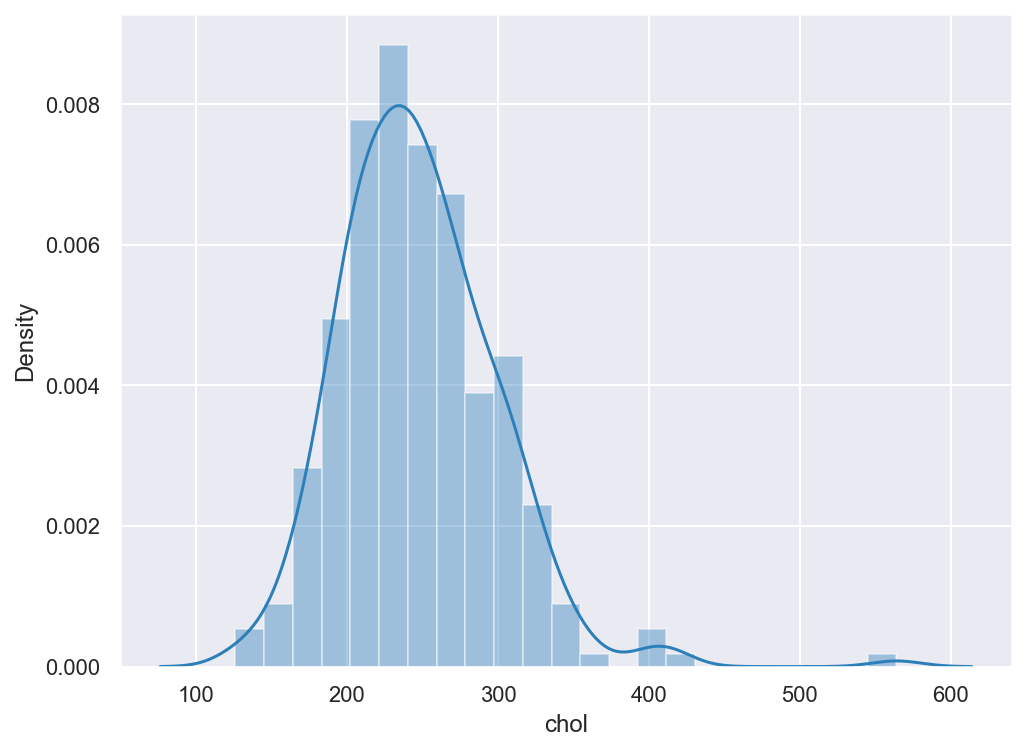

In [17]:
sns.distplot(data.chol, color="#2c7fb9")

In [18]:
sns.distplot(data.trestbps, color="#2c7fb9")

<AxesSubplot:xlabel='trestbps', ylabel='Density'>

<b>Findings</b>

Numerical variable distributions are skewed for thalach and cholestral while trestbps is normally distributed. The need for normalization prior to machine learning is necessary. 

### Outlier Identification

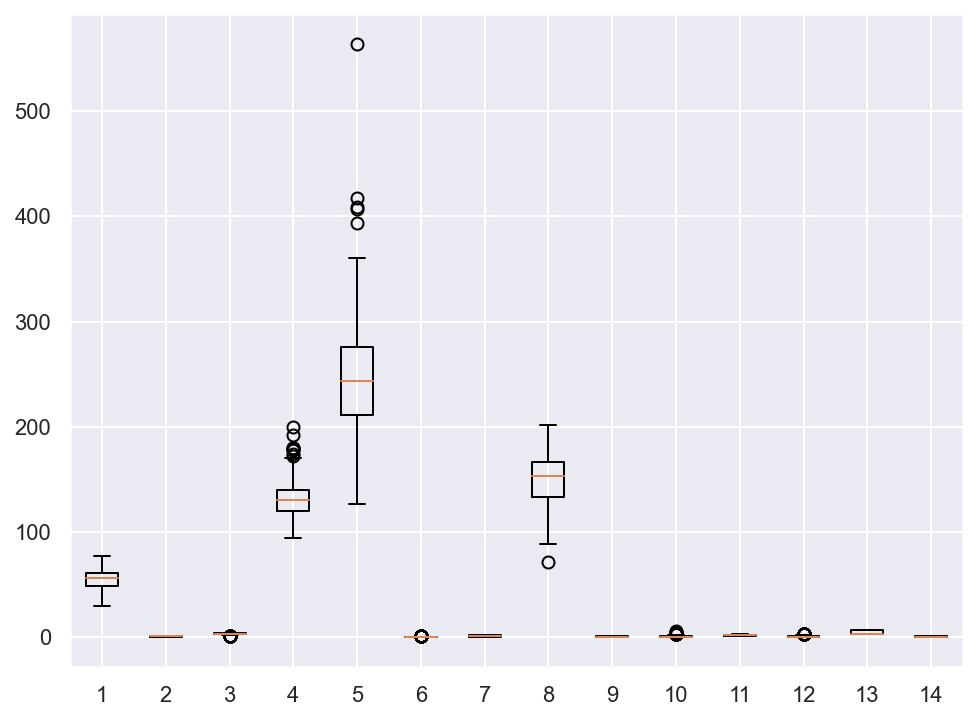

In [19]:
plt.boxplot(data)
plt.show()

<b>Findings</b>

The dataset has some points of influence and shows evidence of outliers in the 5th feature in the box plot above. 

## Bivariate Analysis

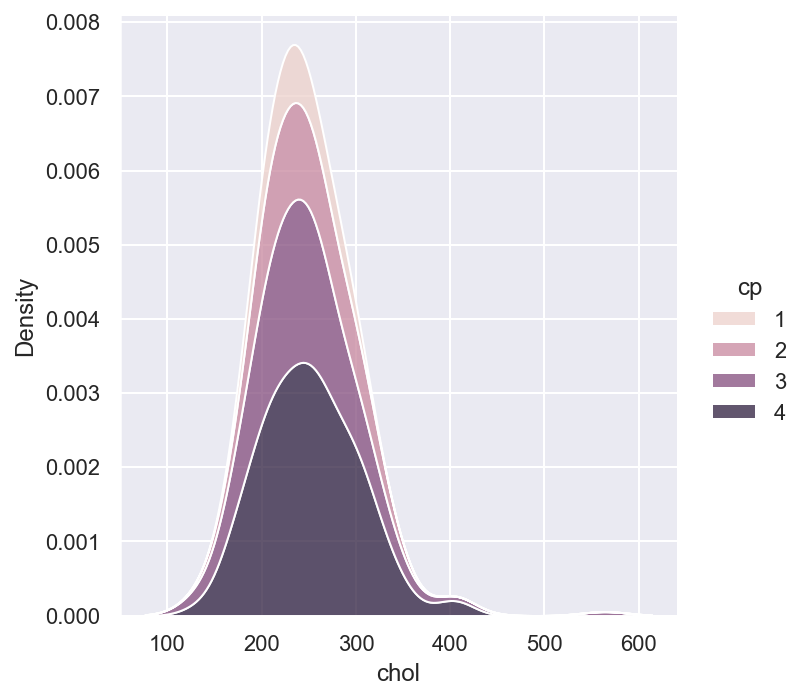

In [20]:
sns.displot(data, x="chol", hue="cp", kind="kde", multiple="stack")

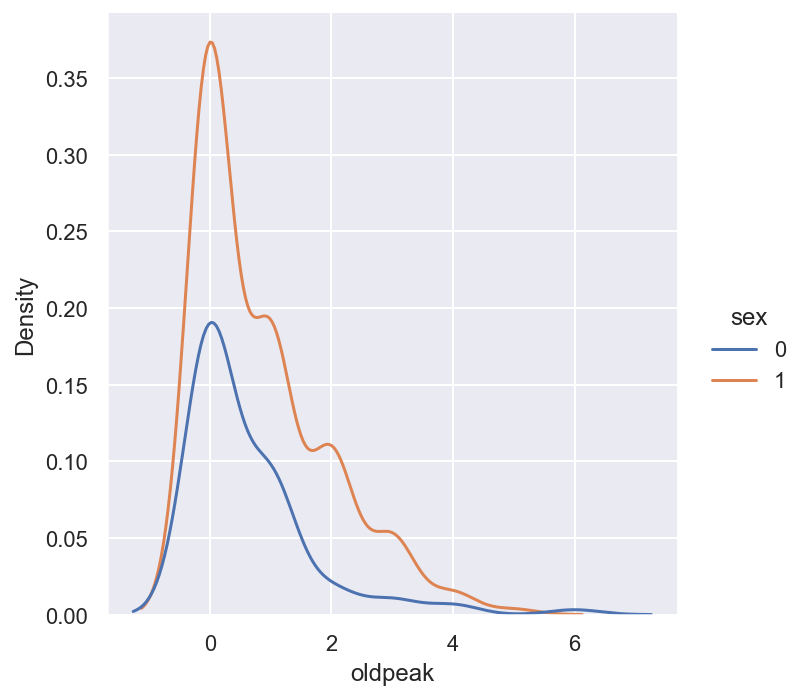

In [21]:
sns.displot(data, x="oldpeak", hue="sex", kind="kde")

<AxesSubplot:xlabel='thalach', ylabel='count'>

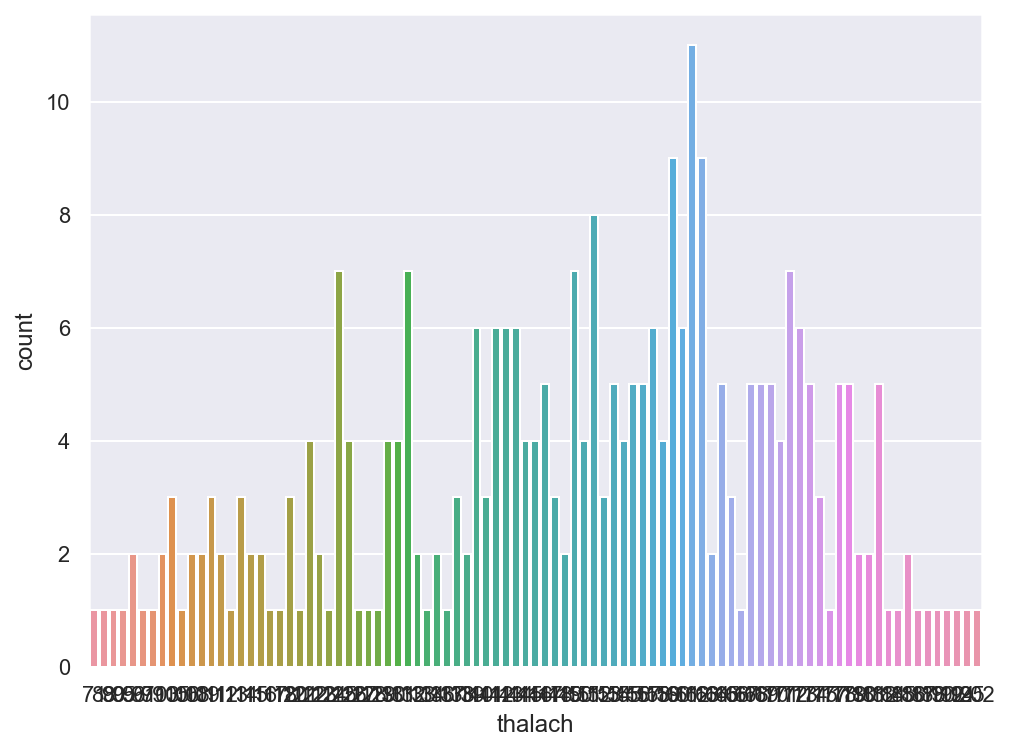

In [22]:
sns.countplot(x='thalach', data=data)

<AxesSubplot:xlabel='oldpeak', ylabel='num'>

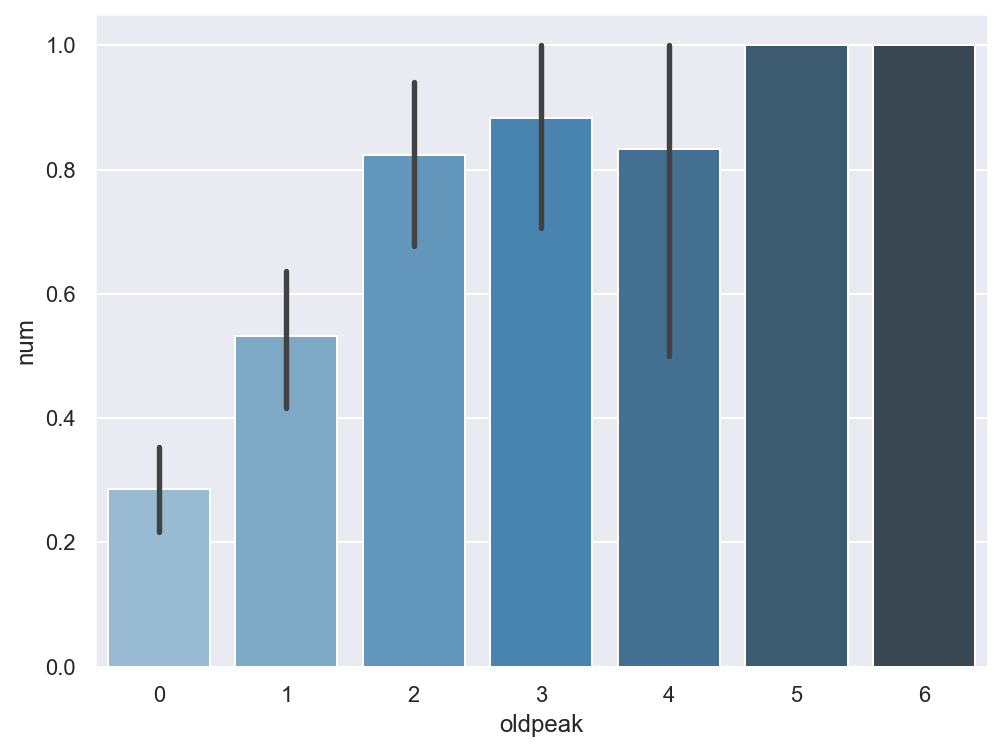

In [23]:
sns.barplot(x="oldpeak", y="num", data=data, palette="Blues_d")

## Data Processing

+ Dummy Encoding
+ Feature Scaling

After exploring the dataset, I observed that I need to convert some categorical variables into dummy variables and scale all the values before training the Machine Learning models. First, I'll use the get_dummies method to create dummy columns for categorical variables.

In [24]:
# Dummy Encoding

data = pd.get_dummies(data, columns = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal'])

## Feature Scaling

In [25]:
# Using the StandardScaler from sklearn to scale dataset.

standardScaler = StandardScaler()
columns_to_scale = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
data[columns_to_scale] = standardScaler.fit_transform(data[columns_to_scale])

In [26]:
# View Scaled Dataset

data

age  trestbps  chol  thalach  oldpeak  num  sex_0  sex_1  cp_1  cp_2  \
0    0.9       0.8  -0.3      0.0      1.1    0      0      1     1     0   
1    1.4       1.6   0.7     -1.8      0.2    1      0      1     0     0   
2    1.4      -0.7  -0.4     -0.9      1.1    1      0      1     0     0   
3   -1.9      -0.1   0.1      1.6      2.1    0      0      1     0     0   
4   -1.5      -0.1  -0.8      1.0      0.2    0      1      0     0     1   
..   ...       ...   ...      ...      ...  ...    ...    ...   ...   ...   
297  0.3       0.5  -0.1     -1.2     -0.7    1      1      0     0     0   
298 -1.1      -1.2   0.3     -0.8      0.2    1      0      1     1     0   
299  1.5       0.7  -1.0     -0.4      2.1    1      0      1     0     0   
300  0.3      -0.1  -2.2     -1.5      0.2    1      0      1     0     0   
301  0.3      -0.1  -0.2      1.1     -0.7    1      1      0     0     1   

     ...  slope_1  slope_2  slope_3  ca_0  ca_1  ca_2  ca_3  thal_3  thal_6  \
0    ...        0        0        1     1     0     0     0       0       1   
1    ...        0        1        0     0     0     0     1       1       0   
2    ...        0        1        0     0     0     1     0       0       0   
3    ...        0        0        1     1     0     0     0       1       0   
4    ...        1        0        0     1     0     0     0       1       0   
..   ...      ...      ...      ...   ...   ...   ...   ...     ...     ...   
297  ...        0        1        0     1     0     0     0       0       0   
298  ...        0        1        0     1     0     0     0       0       0   
299  ...        0        1        0     0     0     1     0       0       0   
300  ...        0        1        0     0     1     0     0       0       0   
301  ...        0        1        0     0     1     0     0       1       0   

     thal_7  
0         0  
1         0  
2         1  
3         0  
4         0  
..      ...  
297       1  
298       1  
299       1  
300       1  
301       0  

[297 rows x 29 columns]

### Train and Test Split

In [27]:
# Splitting the dataset into train and test sets with a 20/80 split size using a defined random seed.

target_col = "num"

X = data.loc[:, data.columns != target_col]
y = data.loc[:, target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

## Modeling

Logistic Regression Model


In [28]:
logistic_regression= LogisticRegression()
logistic_regression.fit(X_train,y_train)
y_pred=logistic_regression.predict(X_test)

Confusion Matrix

<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

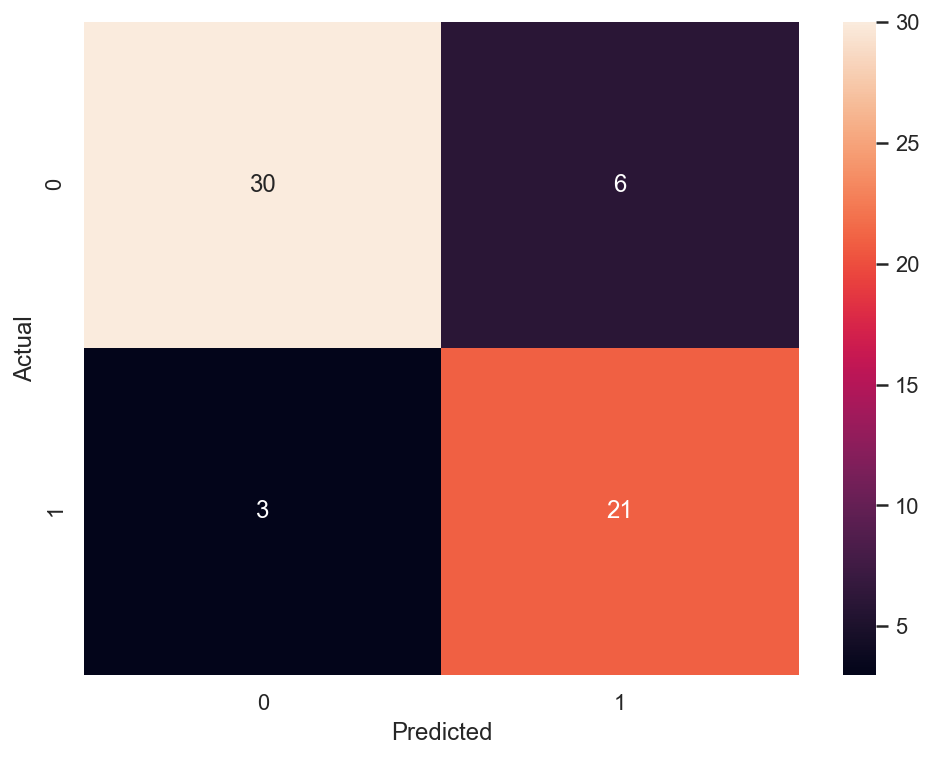

In [30]:
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)

### Accuracy

In [31]:
print('Accuracy: ',metrics.accuracy_score(y_test, y_pred))
plt.show()

Accuracy:  0.85
